# Aperiodic and oscillatory components of the power spectrum

This notebook demonstrates how to use YASA to separate the aperiodic (fractal = $1/f$) components of the EEG power spectra using the IRASA method.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [11]:
import mne
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sovaflow.utils import createRaw

## Datos

Para esta prueba, usé los datos preprocesados (solo PREP) de CTR001.


Usé Closed eyes para tener la referencia del pico en alfa 

In [12]:
# Load data as a MNE Raw file
#raw=mne.io.read_raw_fif('C:/Users/data_analysis/Desktop/sub-CTR001_ses-V0_task-CE_desc-prep_eeg.fif', preload=True, verbose=0)
raw=mne.read_epochs(r'E:\BIOMARCADORES\derivatives\sovaharmony\sub-CTR001\ses-V0\eeg\sub-CTR001_ses-V0_task-OE_desc-reject[restOE]_eeg.fif', preload=True, verbose=0)
signalc=raw.copy()
(e, c, t) = signalc._data.shape
signal_data = signalc.get_data()
da_eeg_cont = np.concatenate(signal_data,axis=-1)
for e in range(signal_data.shape[0]):
    for c in range(signal_data.shape[1]):
        assert np.all(signal_data[e,c,:] == da_eeg_cont[c,e*t:(e+1)*t])
signal_ch = createRaw(da_eeg_cont,signalc.info['sfreq'],ch_names=signalc.info['ch_names'])
# raw2= mne.io.read_raw_fif()

# Extract data, sf, and chan
data = raw.get_data(units="uV")
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', len(chan),chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)
#print('Duration =', data.shape[1] / sf, 'seconds')
print('Duration =', (data.shape[0]*data.shape[2]) / sf, 'seconds')

C:\Users\Luisa\AppData\Local\Temp\ipykernel_12756\1799248835.py:3: RuntimeWarning: This filename (E:\BIOMARCADORES\derivatives\sovaharmony\sub-CTR001\ses-V0\eeg\sub-CTR001_ses-V0_task-OE_desc-reject[restOE]_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  raw=mne.read_epochs(r'E:\BIOMARCADORES\derivatives\sovaharmony\sub-CTR001\ses-V0\eeg\sub-CTR001_ses-V0_task-OE_desc-reject[restOE]_eeg.fif', preload=True, verbose=0)


Chan = 58 ['CPZ', 'PO6', 'PO7', 'F4', 'C4', 'F8', 'TP7', 'FPZ', 'AF4', 'CP6', 'C3', 'P7', 'PZ', 'OZ', 'F5', 'FC4', 'FC6', 'PO8', 'P5', 'CP2', 'FC3', 'FP2', 'FP1', 'PO4', 'TP8', 'P2', 'O2', 'FC1', 'CZ', 'FCZ', 'POZ', 'AF3', 'C6', 'FC5', 'O1', 'CP1', 'F7', 'FZ', 'P8', 'PO3', 'T7', 'CP3', 'P6', 'F1', 'F2', 'F6', 'C2', 'F3', 'FC2', 'T8', 'CP5', 'P1', 'P3', 'C5', 'C1', 'CP4', 'P4', 'PO5']
Sampling frequency = 1000.0 Hz
Data shape = (52, 58, 5000)
Duration = 260.0 seconds


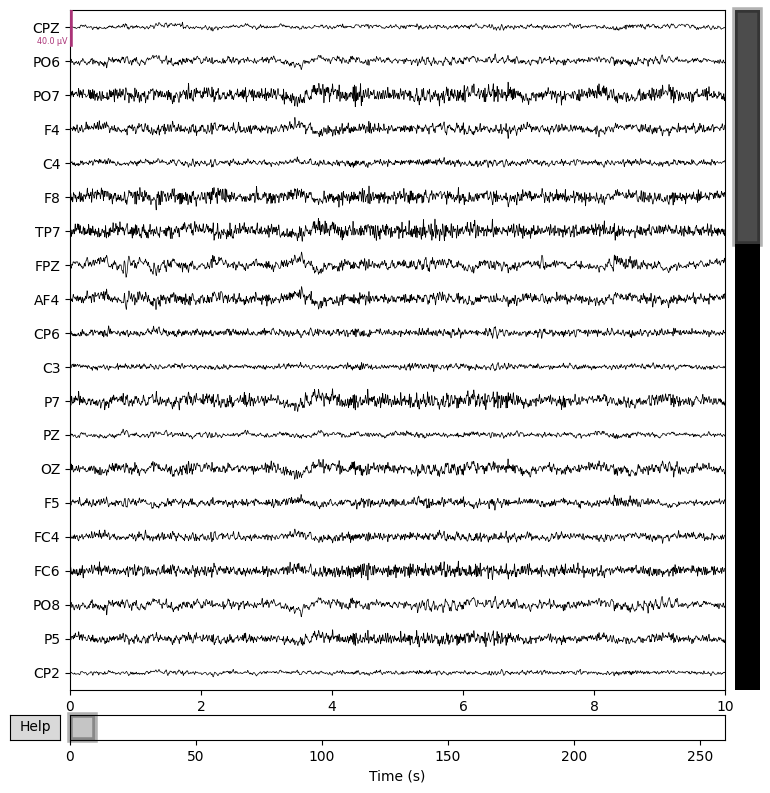

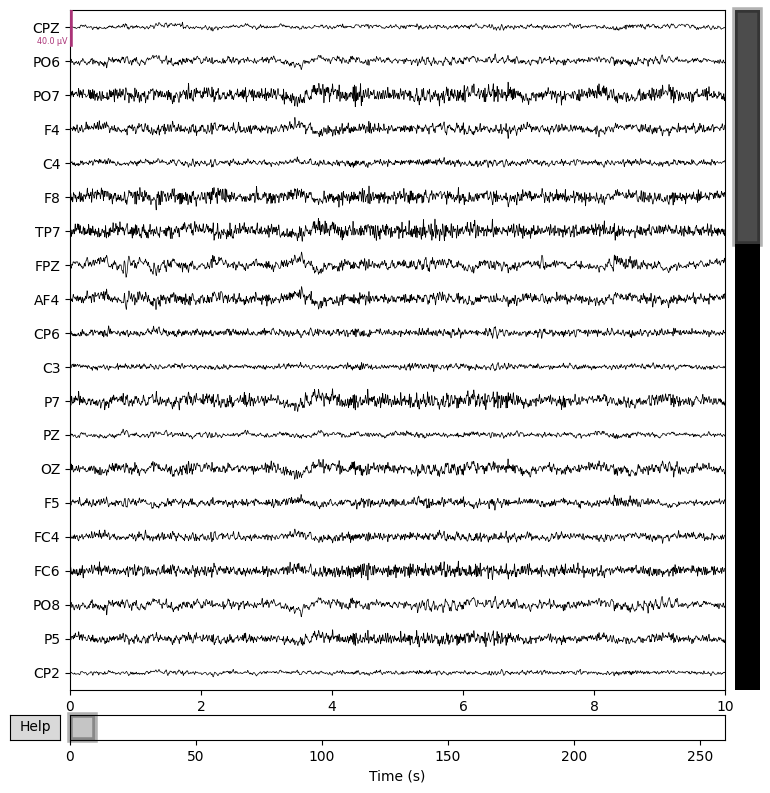

In [13]:
signal_ch.plot()

Se observan ritmos alfa occipitales y parietales.


También hay ruidos de alta amplitud que espero se hayan removido luego de ICA y el último pedazo del preprocesamiento

**************

## Diferencias entre multitaper y Welch

Nota que IRASA implementa un welch por debajo. En IRASA se especifican DOS parámetros del Welch de Scipy. Así, yasa.irasa tiene los kwargs_welch=dict(average="median", window="hamming").

Hasta donde yo he visto, siempre ha existido bastante debate entre medias y medianas para el Welch (por ejemplo MNE usa medias mientras YASA usa medianas por default).




In [14]:
#Miremos un canal con claro ritmo alfa posterior
chan[0]

'CPZ'

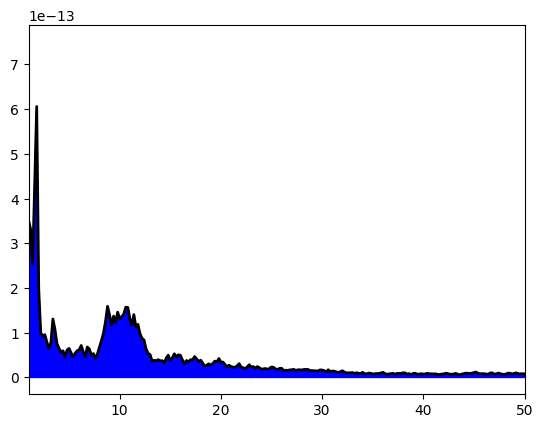

In [52]:
from scipy.signal import welch

win = int(5 * sf)  # Window size is set to 5 seconds
freqs, psd = welch(signal_ch.get_data(), sf, nperseg=win, average = 'median')  # Works with single or multi-channel data

#print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

import seaborn as sns

# # Plot
plt.plot(freqs, psd[0, :], 'k', lw=2)
plt.fill_between(freqs, psd[0, :], color = 'b')
plt.xlim(1, 50)
#plt.yscale('log')

#plt.ylim(0.1, 20)
plt.show()

    Using multitaper spectrum estimation with 1 DPSS windows


C:\Users\Luisa\AppData\Local\Temp\ipykernel_12756\3597044095.py:3: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  psd, freqs = mne.time_frequency.psd_array_multitaper(signal_ch.get_data(), sfreq= sf, fmin=1, fmax =50, normalization = 'full', n_jobs=-1)  # Works with single or multi-channel data


(12741,) (58, 12741)


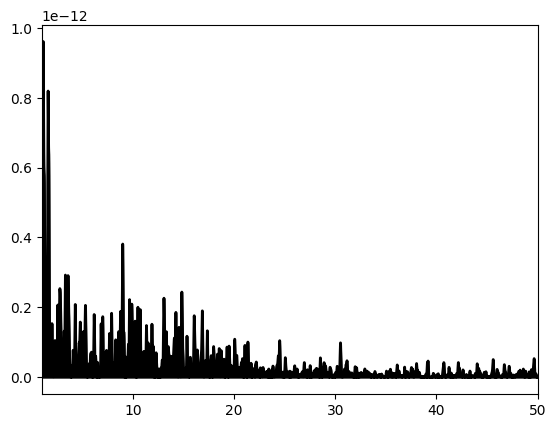

In [51]:
# COMPARADO CON MULTITAPER

psd, freqs = mne.time_frequency.psd_array_multitaper(signal_ch.get_data(), sfreq= sf, fmin=1, fmax =50, normalization = 'full', n_jobs=-1)  # Works with single or multi-channel data

print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

import seaborn as sns

# Plot
plt.plot(freqs, psd[0, :], 'k', lw=2)
plt.fill_between(freqs, psd[0, :], color = 'k')
plt.xlim(1, 50)
#plt.yscale('log')

#plt.ylim(0.1, 20)

plt.show()

Cuando tomamos el espectro hasta 45 Hz no aparece ningún canal ajustado más de 0.7, en 45 Hz salen solo 5 canales que ajustan más de 0.7, en 35 Hz - 27 y 30 Hz - 24 canales, para el CTR001

In [59]:
# Apply the IRASA technique
freqs, psd_aperiodic, psd_osc,fit_params = yasa.irasa(signal_ch.get_data(), sf, ch_names=raw.info['ch_names'], band=(1, 30), win_sec=5, return_fit=True)

In [60]:
fit_params

,Chan,Intercept,Slope,R^2,std(osc)
0,CPZ,-28.705891,-0.835761,0.882356,5.584493e-14
1,PO6,-28.403878,-0.579899,0.800116,1.238573e-13
2,PO7,-28.906448,0.022990,0.007218,3.062027e-13
3,F4,-28.913792,-0.201558,0.443661,8.013223e-14
4,C4,-29.545975,-0.285575,0.573813,3.789505e-14
5,F8,-28.679520,-0.127306,0.172446,9.709993e-14
6,TP7,-30.090277,0.454312,0.601573,1.241034e-13
7,FPZ,-26.790952,-0.920904,0.967133,1.776739e-13
8,AF4,-28.030170,-0.438873,0.841559,1.188151e-13
9,CP6,-29.802380,-0.068830,0.050913,5.080093e-14


In [61]:
# Fitting df filtrado (SOLO 17 CANALES TIENEN 'BUEN' R CUADRADO)
filtered_data = fit_params[fit_params['R^2'] >= 0.7]

filtered_data, len(filtered_data)


(   Chan  Intercept     Slope       R^2      std(osc)
 0   CPZ -28.705891 -0.835761  0.882356  5.584493e-14
 1   PO6 -28.403878 -0.579899  0.800116  1.238573e-13
 7   FPZ -26.790952 -0.920904  0.967133  1.776739e-13
 8   AF4 -28.030170 -0.438873  0.841559  1.188151e-13
 12   PZ -28.299969 -0.866780  0.947394  2.240614e-13
 14   F5 -28.469682 -0.405540  0.771701  8.369361e-14
 19  CP2 -29.492246 -0.575810  0.731862  2.999762e-14
 21  FP2 -26.918628 -0.802314  0.966673  1.684408e-13
 22  FP1 -26.965147 -0.791159  0.972356  1.772134e-13
 23  PO4 -28.401554 -0.611362  0.862169  1.034232e-13
 25   P2 -28.794104 -0.705050  0.890122  4.045020e-14
 26   O2 -28.265956 -0.417667  0.700799  2.973478e-13
 27  FC1 -28.779293 -0.590763  0.786163  1.285146e-13
 30  POZ -27.968526 -0.723725  0.921806  5.249813e-13
 31  AF3 -27.709028 -0.691807  0.927823  1.186637e-13
 35  CP1 -29.334516 -0.538645  0.830854  4.582137e-14
 37   FZ -28.052115 -0.717419  0.884888  9.660501e-14
 39  PO3 -28.726080 -0.42242

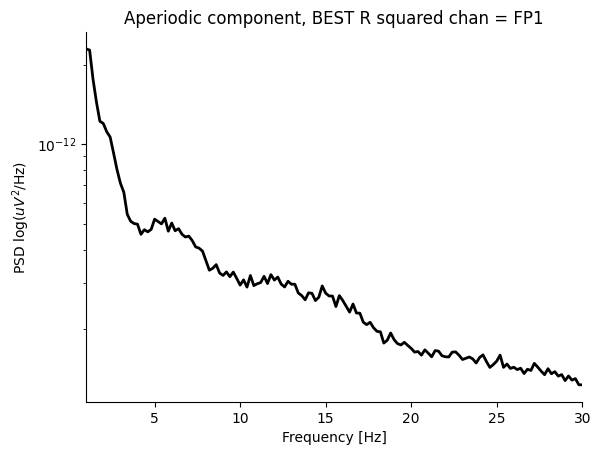

In [64]:
# Plot the aperiodic component on a linear-log scale
plt.plot(freqs, psd_aperiodic[22, :], 'k', lw=2)
plt.xlim(1, 30)
plt.yscale('log')
sns.despine()
plt.title('Aperiodic component, BEST R squared chan = ' + chan[22])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)')
plt.show()

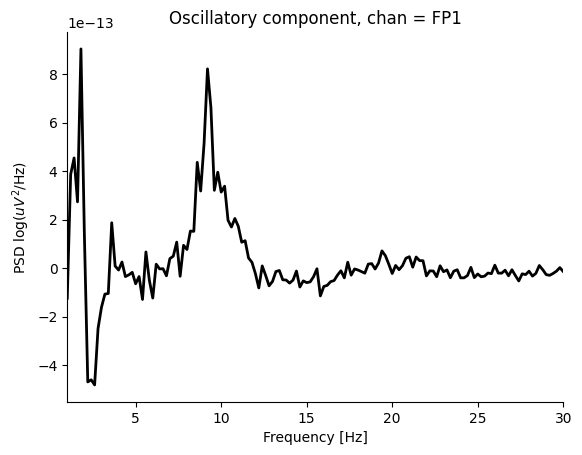

In [65]:
# Plot the oscillatory component on a linear-linear scale
plt.plot(freqs, psd_osc[22, :], 'k', lw=2)
plt.xlim(1, 30)
sns.despine()
plt.title('Oscillatory component, chan = ' + chan[22])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)')
plt.show()

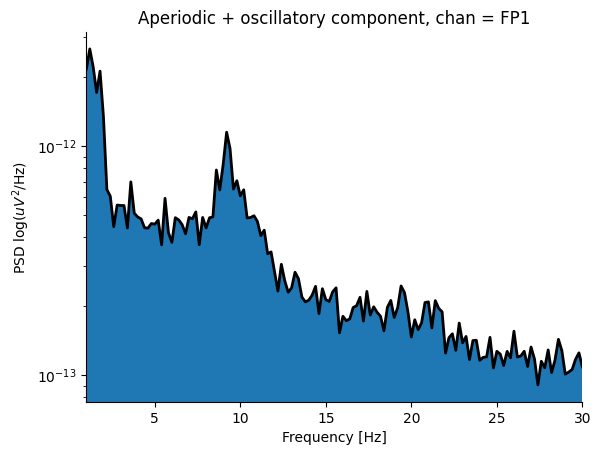

In [66]:
# Plot the oscillatory + aperiodic component on a linear-log scale
psd_combined = psd_aperiodic[22, :] + psd_osc[22, :]
plt.plot(freqs, psd_combined, 'k', lw=2)
plt.fill_between(freqs, psd_combined, cmap='Spectral')
plt.xlim(1, 30)
plt.yscale('log')
sns.despine()
plt.title('Aperiodic + oscillatory component, chan = ' + chan[22])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)')
plt.show()

## Fit the fractal component (1/f)

If `return_fit=True` (default), `yasa.irasa` [fits an exponential function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to the aperiodic power spectrum and return the fit parameters (intercept, slope), the $R^2$ of the fit, and the standard deviation of the oscillatory component.

The aperiodic signal, $L$, is modeled using an exponential function in semilog-power space (linear frequencies and log PSD) as:

$L = a + log(F^b)$

where $a$ is the intercept, $b$ is the slope, and $F$ the vector of input frequencies.

In [68]:
# Apply the IRASA technique
freqs, psd_aperiodic, psd_osc,fit_params = yasa.irasa(signal_ch.get_data(), sf, kwargs_welch=dict(average="median", window="hann"), ch_names=raw.info['ch_names'], band=(1, 30), win_sec=5, return_fit=True)
fit_params

,Chan,Intercept,Slope,R^2,std(osc)
0,CPZ,-28.699843,-0.838043,0.883523,5.488556e-14
1,PO6,-28.416888,-0.574904,0.798457,1.238767e-13
2,PO7,-28.905020,0.022761,0.006973,3.057891e-13
3,F4,-28.917698,-0.200874,0.450475,8.312381e-14
4,C4,-29.546305,-0.286989,0.572367,3.823683e-14
5,F8,-28.682911,-0.127854,0.166571,9.657268e-14
6,TP7,-30.086458,0.452474,0.598581,1.168672e-13
7,FPZ,-26.787494,-0.922297,0.965720,1.776614e-13
8,AF4,-28.019186,-0.443803,0.843266,1.197037e-13
9,CP6,-29.808951,-0.066994,0.047773,4.796456e-14


In [69]:
filtered_data = fit_params[fit_params['R^2'] >= 0.7]

filtered_data, len(filtered_data)


(   Chan  Intercept     Slope       R^2      std(osc)
 0   CPZ -28.699843 -0.838043  0.883523  5.488556e-14
 1   PO6 -28.416888 -0.574904  0.798457  1.238767e-13
 7   FPZ -26.787494 -0.922297  0.965720  1.776614e-13
 8   AF4 -28.019186 -0.443803  0.843266  1.197037e-13
 12   PZ -28.277915 -0.875518  0.949566  2.163610e-13
 14   F5 -28.457369 -0.410074  0.763628  8.412351e-14
 19  CP2 -29.496755 -0.574899  0.734725  2.918096e-14
 21  FP2 -26.922482 -0.800162  0.967838  1.705528e-13
 22  FP1 -26.970382 -0.790208  0.972317  1.804357e-13
 23  PO4 -28.395497 -0.614241  0.865906  1.026258e-13
 25   P2 -28.792173 -0.707249  0.892579  3.891849e-14
 27  FC1 -28.771464 -0.593906  0.783081  1.236682e-13
 30  POZ -27.957371 -0.728955  0.917213  5.133766e-13
 31  AF3 -27.713650 -0.689529  0.928174  1.135570e-13
 35  CP1 -29.321896 -0.543851  0.831369  4.282292e-14
 37   FZ -28.055187 -0.717880  0.885439  9.481354e-14
 39  PO3 -28.732404 -0.420240  0.801995  9.927408e-14
 43   F1 -28.226574 -0.64907

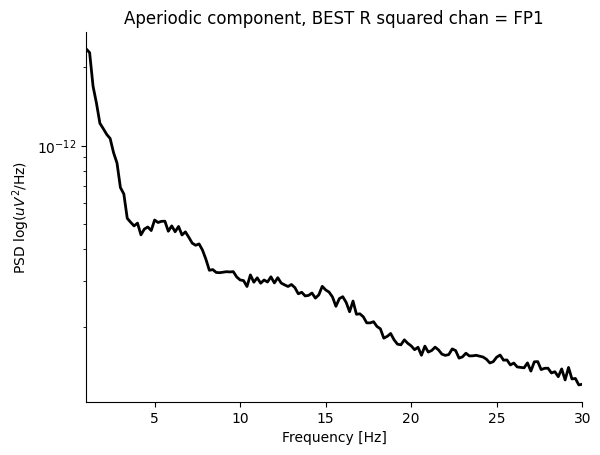

In [71]:
# Plot the aperiodic component on a linear-log scale
plt.plot(freqs, psd_aperiodic[22, :], 'k', lw=2)
plt.xlim(1, 30)
plt.yscale('log')
sns.despine()
plt.title('Aperiodic component, BEST R squared chan = ' + chan[22])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)')
plt.show()

# **FOOOF**

In [ ]:
#epochs = mne.make_fixed_length_epochs(raw, duration=5, preload=True)

(1) the maximum number of peaks; (2) limits on the possible bandwidth of extracted peaks; and (3) absolute, rather than relative, power thresholds.

In [73]:
!pip install fooof

You should consider upgrading via the 'D:\flujo_portables\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [84]:
import pandas as pd
import fooof
from fooof.analysis import get_band_peak_fm
from fooof import FOOOF, FOOOFGroup
from fooof.bands import Bands


dict_list = []
epochs= signalc.filter(l_freq=1, h_freq=30)
#epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
#nepochs,nchannels,npoints = epochs._data.shape
channels = epochs.info['ch_names']
psds=[]
for ch, ch_label in enumerate(channels):
    psd, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data()[:,ch,:], sfreq = raw.info['sfreq'],fmin=1, fmax=30, n_jobs=-1)
    psd = np.median(psd,0) # get median psd vector per channel
    psds.append(psd)
    fm = FOOOF(min_peak_height=0.05, aperiodic_mode='knee') # peak_width_limits=[1, 8], , max_n_peaks=6, 
    # Initialize FOOOF object
    # Define frequency range across which to model the spectrum
    freq_range = [1, 45]
    fm.fit(freqs, psd, freq_range)   # Fit the power spectrum model
    # Define frequency bands of interest
    bands = Bands({'extalpha' : [5, 14],'beta' : [13, 30]})
    # Extract params
    betas = get_band_peak_fm(fm, bands.beta)
    extalphas = get_band_peak_fm(fm, bands.extalpha)

    aperiodic = fm.get_params('aperiodic_params')
    fit = [fm.get_params('r_squared'), fm.get_params('error')]
    features = {}
    features['channel'] = ch_label
    features['beta_cf'] = betas[0]
    features['beta_pw'] = betas[1]
    features['beta_bw'] = betas[2]
    features['extalphas_cf'] = extalphas[0]
    features['extalphas_pw'] = extalphas[1]
    features['extalphas_bw'] = extalphas[2]
    features['exponent'] = aperiodic[1]
    features['offset'] = aperiodic[0]
    features['r_squared'] = fit[0]
    features['error'] = fit[1]
    dict_list.append(features)
df = pd.DataFrame(dict_list)
df

Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:   11.3s


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

,channel,beta_cf,beta_pw,beta_bw,extalphas_cf,extalphas_pw,extalphas_bw,exponent,offset,r_squared,error
0,CPZ,NaN,NaN,NaN,8.950237,0.426311,1.157264,1.905429e-01,-9.494396,0.920403,0.085633
1,PO6,22.420838,0.110959,2.484200,9.608945,0.628984,2.225114,3.828490e+01,-8.076003,0.899586,0.067504
2,PO7,NaN,NaN,NaN,9.249642,0.799140,2.060135,-9.609025e-01,-11.066753,0.693078,0.070831
3,F4,20.133581,0.175653,3.154704,9.247647,0.465297,1.884228,-5.326353e-01,-10.154780,0.948287,0.026036
4,C4,14.002258,0.128544,2.068230,9.087523,0.473779,1.499669,-9.983664e-01,-12.638533,0.813412,0.062124
5,F8,20.804041,0.177150,2.122582,8.905770,0.385322,1.013894,-9.996053e-01,-12.804622,0.562217,0.065217
6,TP7,19.683100,0.301508,3.092529,9.116397,0.511311,2.438574,-9.948442e-01,-12.405688,0.733622,0.088530
7,FPZ,21.155285,0.116702,3.188325,9.622327,0.366488,1.091312,1.768112e+00,-8.375565,0.965687,0.051298
8,AF4,21.050786,0.097029,3.014699,9.314950,0.405443,2.091772,-9.975972e-01,-11.797178,0.974502,0.024168
9,CP6,NaN,NaN,NaN,11.641074,0.491128,4.764748,-9.338397e-01,-11.245156,0.620105,0.087963


In [85]:
filtered_data = df[df['r_squared'] >= 0.99]

filtered_data, len(filtered_data)

(   channel    beta_cf   beta_pw   beta_bw  extalphas_cf  extalphas_pw  \
 21     FP2  21.167672  0.110553  1.344183      9.820859      0.327445   
 
     extalphas_bw   exponent    offset  r_squared     error  
 21      1.245917  19.416178 -7.889186   0.993981  0.019159  ,
 1)

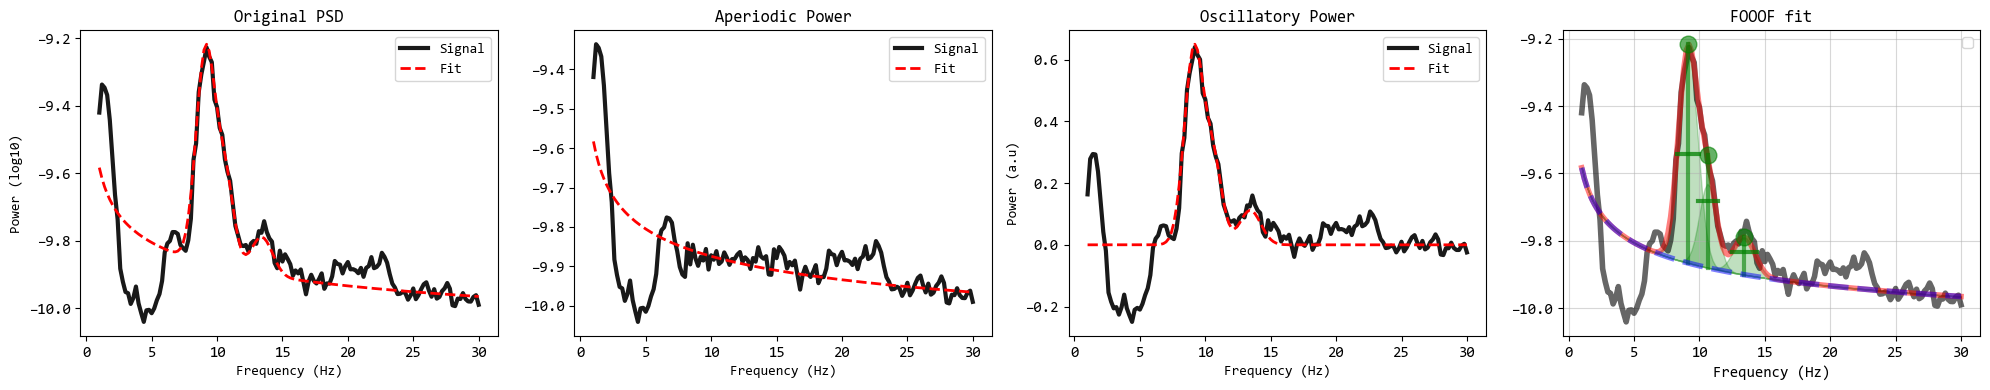

In [82]:
from fooof.plts.annotate import plot_annotated_model

# Customize font style
plt.rcParams['font.family'] = 'Consolas'

fig, axs = plt.subplots(figsize=(20, 4), ncols=4)



# Get FOOOF fitting vectors

osc_fit = fm._peak_fit 
psd_fit = fm.fooofed_spectrum_
ap_fit = fm._ap_fit

# Get FOOOF reconstructed oscillatory and aperiodic power vectors
spect_flat = fm._spectrum_flat
aperiodic = fm._spectrum_peak_rm

# Plot 1 - Original Power
axs[0].plot(freqs, np.log10(psd), label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[0].plot(freqs, psd_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
#axs[0].set_ylim(-13, -11)
axs[0].set_title('Original PSD')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power (log10)')
axs[0].legend(loc='upper right')

# Plot 2 - Aperiodic Power 
axs[1].plot(freqs, aperiodic, label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[1].plot(freqs, ap_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
#axs[1].set_ylim(-13, -11)
axs[1].set_title('Aperiodic Power')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].legend(loc='upper right')

# Plot 3 - Oscillatory Power 
axs[2].plot(freqs, spect_flat, label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[2].plot(freqs, osc_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
axs[2].set_title('Oscillatory Power')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power (a.u)')
axs[2].legend(loc='upper right')

# Plot annotated model of aperiodic parameters
plot_annotated_model(fm, annotate_peaks=False, annotate_aperiodic=False, ax = axs[3], plt_log=False, )
axs[3].set_title('FOOOF fit')
axs[3].legend([])
axs[3].set_xlabel('Frequency (Hz)', size = 11)
axs[3].set_ylabel('')

# Reduce tick label size for all subplots
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=11)  # Adjust fontsize here

plt.show()



In [86]:
import pandas as pd
import fooof
from fooof.analysis import get_band_peak_fm
from fooof import FOOOF, FOOOFGroup
from fooof.bands import Bands


dict_list = []
epochs = signalc.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
nepochs,nchannels,npoints = epochs._data.shape
channels = epochs.info['ch_names']
for ch, ch_label in enumerate(channels):
    psd, freqs = mne.time_frequency.psd_array_multitaper(signalc.get_data()[:,ch,:], sfreq = raw.info['sfreq'],fmin=1, fmax=30, n_jobs=-1)
    psd = np.median(psd,0) # get median psd vector per channel
    fm = FOOOF(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=2, aperiodic_mode='knee')
    # Initialize FOOOF object
    # Define frequency range across which to model the spectrum
    freq_range = [1, 30]
    fm.fit(freqs, psd, freq_range)   # Fit the power spectrum model
    # Define frequency bands of interest
    bands = Bands({'extalpha' : [5, 14],'beta' : [13, 30]})
    # Extract params
    betas = get_band_peak_fm(fm, bands.beta)
    extalphas = get_band_peak_fm(fm, bands.extalpha)

    aperiodic = fm.get_params('aperiodic_params')
    fit = [fm.get_params('r_squared'), fm.get_params('error')]
    features = {}
    features['channel'] = ch_label
    features['beta_cf'] = betas[0]
    features['beta_pw'] = betas[1]
    features['beta_bw'] = betas[2]
    features['extalphas_cf'] = extalphas[0]
    features['extalphas_pw'] = extalphas[1]
    features['extalphas_bw'] = extalphas[2]
    features['exponent'] = aperiodic[1]
    features['offset'] = aperiodic[0]
    features['r_squared'] = fit[0]
    features['error'] = fit[1]
    dict_list.append(features)
df = pd.DataFrame(dict_list)
df


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    5.8s


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

,channel,beta_cf,beta_pw,beta_bw,extalphas_cf,extalphas_pw,extalphas_bw,exponent,offset,r_squared,error
0,CPZ,NaN,NaN,NaN,10.285429,0.445556,2.879231,1.857129e-01,-9.498668,0.910991,0.089638
1,PO6,NaN,NaN,NaN,9.601668,0.624632,2.260812,4.093472e+01,-8.050571,0.891404,0.072964
2,PO7,NaN,NaN,NaN,9.265289,0.765858,2.047972,-9.767280e-01,-11.400630,0.875974,0.053021
3,F4,NaN,NaN,NaN,9.379449,0.440357,2.429734,1.190685e-01,-9.802086,0.790536,0.055348
4,C4,NaN,NaN,NaN,10.369665,0.400707,3.811411,-9.987298e-01,-12.769397,0.741678,0.077268
5,F8,NaN,NaN,NaN,10.527686,0.305525,3.920163,-9.963529e-01,-11.946609,0.260641,0.096650
6,TP7,NaN,NaN,NaN,11.914632,0.344406,8.000000,-8.807193e-01,-11.065142,0.527297,0.140113
7,FPZ,NaN,NaN,NaN,9.380686,0.362127,2.338248,1.498600e+00,-8.422925,0.953709,0.064615
8,AF4,NaN,NaN,NaN,9.405683,0.395388,2.335655,-9.987726e-01,-12.152875,0.933380,0.039725
9,CP6,NaN,NaN,NaN,11.648667,0.492466,4.759655,-9.542920e-01,-11.408844,0.622062,0.087738


In [87]:
filtered_data = df[df['r_squared'] >= 0.7]

filtered_data, len(filtered_data)


(   channel  beta_cf  beta_pw  beta_bw  extalphas_cf  extalphas_pw  \
 0      CPZ      NaN      NaN      NaN     10.285429      0.445556   
 1      PO6      NaN      NaN      NaN      9.601668      0.624632   
 2      PO7      NaN      NaN      NaN      9.265289      0.765858   
 3       F4      NaN      NaN      NaN      9.379449      0.440357   
 4       C4      NaN      NaN      NaN     10.369665      0.400707   
 7      FPZ      NaN      NaN      NaN      9.380686      0.362127   
 8      AF4      NaN      NaN      NaN      9.405683      0.395388   
 12      PZ      NaN      NaN      NaN     10.864183      0.451250   
 13      OZ      NaN      NaN      NaN      9.368640      0.872228   
 14      F5      NaN      NaN      NaN      9.909686      0.382356   
 17     PO8      NaN      NaN      NaN      9.382158      0.774174   
 19     CP2      NaN      NaN      NaN     10.201177      0.536280   
 21     FP2      NaN      NaN      NaN      9.472904      0.335158   
 22     FP1      NaN

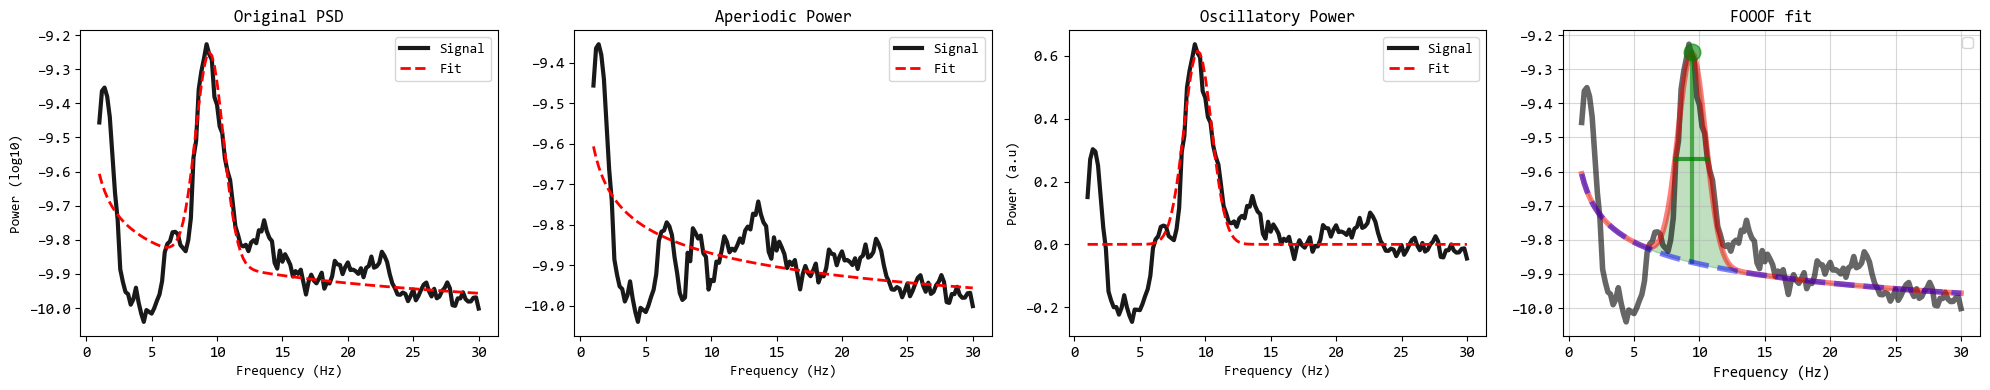

In [88]:
from fooof.plts.annotate import plot_annotated_model

# Customize font style
plt.rcParams['font.family'] = 'Consolas'

fig, axs = plt.subplots(figsize=(20, 4), ncols=4)



# Get FOOOF fitting vectors

osc_fit = fm._peak_fit 
psd_fit = fm.fooofed_spectrum_
ap_fit = fm._ap_fit

# Get FOOOF reconstructed oscillatory and aperiodic power vectors
spect_flat = fm._spectrum_flat
aperiodic = fm._spectrum_peak_rm

# Plot 1 - Original Power
axs[0].plot(freqs, np.log10(psd), label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[0].plot(freqs, psd_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
#axs[0].set_ylim(-13, -11)
axs[0].set_title('Original PSD')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power (log10)')
axs[0].legend(loc='upper right')

# Plot 2 - Aperiodic Power 
axs[1].plot(freqs, aperiodic, label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[1].plot(freqs, ap_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
#axs[1].set_ylim(-13, -11)
axs[1].set_title('Aperiodic Power')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].legend(loc='upper right')

# Plot 3 - Oscillatory Power 
axs[2].plot(freqs, spect_flat, label='Signal', linewidth=3, color='k', alpha = 0.9)
axs[2].plot(freqs, osc_fit, color='red', linestyle= 'dashed',linewidth=2,  label='Fit')
axs[2].set_title('Oscillatory Power')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power (a.u)')
axs[2].legend(loc='upper right')

# Plot annotated model of aperiodic parameters
plot_annotated_model(fm, annotate_peaks=False, annotate_aperiodic=False, ax = axs[3], plt_log=False, )
axs[3].set_title('FOOOF fit')
axs[3].legend([])
axs[3].set_xlabel('Frequency (Hz)', size = 11)
axs[3].set_ylabel('')

# Reduce tick label size for all subplots
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=11)  # Adjust fontsize here

plt.show();



In [89]:
dict_list = []
epochs = signalc.filter(l_freq=1, h_freq=30)  # bandpassing 1-30Hz
nepochs, nchannels, npoints = epochs._data.shape
channels = epochs.info['ch_names']

for ch, ch_label in enumerate(channels):
    psd, freqs = mne.time_frequency.psd_array_multitaper(signalc.get_data()[:, ch, :], sfreq=raw.info['sfreq'],
                                                         fmin=1, fmax=30, n_jobs=-1)
    psd = np.median(psd, 0)  # get median psd vector per channel
    fm = FOOOF()#peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=2, aperiodic_mode='knee')
    # Initialize FOOOF object
    # Define frequency range across which to model the spectrum
    freq_range = [1, 30]
    fm.fit(freqs, psd, freq_range)  # Fit the power spectrum model

    # Extract FOOOF vectors
    osc_fit = fm._peak_fit
    psd_fit = fm.fooofed_spectrum_
    ap_fit = fm._ap_fit
    spect_flat = fm._spectrum_flat
    aperiodic = fm._spectrum_peak_rm

    # Define frequency bands of interest
    bands = Bands({'extalpha': [5, 14], 'beta': [13, 30]})
    # Extract params
    betas = get_band_peak_fm(fm, bands.beta)
    extalphas = get_band_peak_fm(fm, bands.extalpha)

    aperiodic_params = fm.get_params('aperiodic_params')
    fit_params = [fm.get_params('r_squared'), fm.get_params('error')]

    features = {
        'channel': ch_label,
        'beta_cf': betas[0],
        'beta_pw': betas[1],
        'beta_bw': betas[2],
        'extalphas_cf': extalphas[0],
        'extalphas_pw': extalphas[1],
        'extalphas_bw': extalphas[2],
        'exponent': aperiodic_params[1],
        'offset': aperiodic_params[0],
        'r_squared': fit_params[0],
        'error': fit_params[1],
        'osc_fit': osc_fit,
        'psd_fit': psd_fit,
        'ap_fit': ap_fit,
        'spect_flat': spect_flat,
        'aperiodic': aperiodic
    }

    dict_list.append(features)

df = pd.DataFrame(dict_list)



Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    7.7s


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

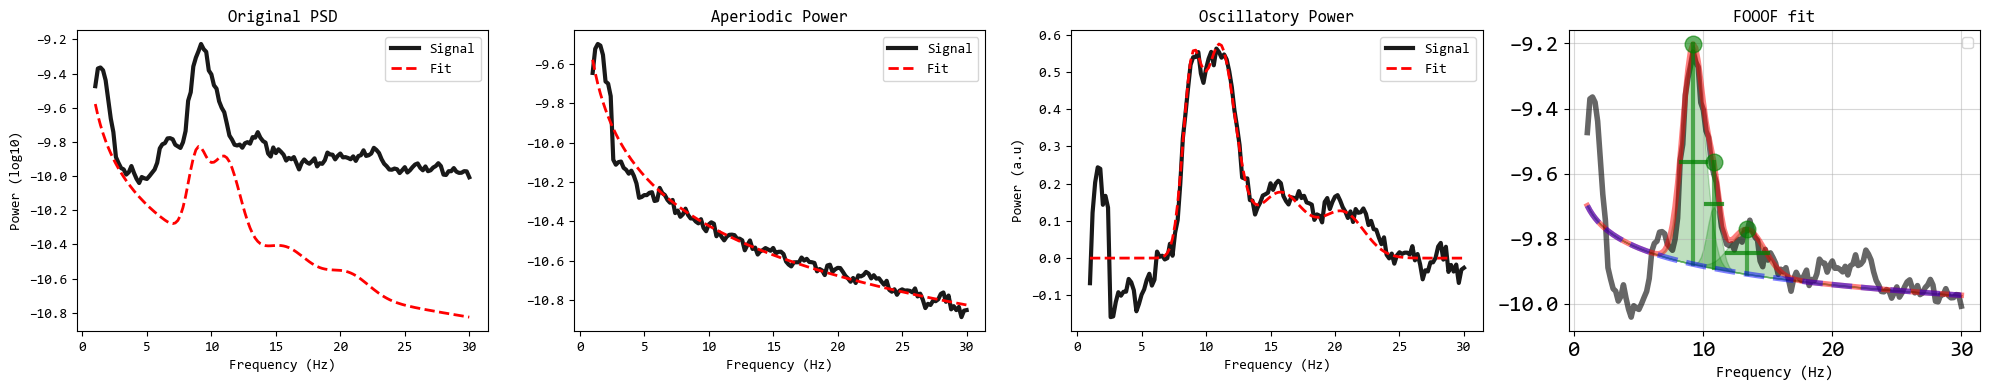

In [92]:
import matplotlib.pyplot as plt
from fooof.plts.annotate import plot_annotated_model

# Customize font style
plt.rcParams['font.family'] = 'Consolas'

# Select the channel index from the DataFrame (change index accordingly)
channel_index_to_plot = 0
selected_channel = df.iloc[channel_index_to_plot]

# Get FOOOF fitting vectors
osc_fit = selected_channel['osc_fit']
psd_fit = selected_channel['psd_fit']
ap_fit = selected_channel['ap_fit']

# Get FOOOF reconstructed oscillatory and aperiodic power vectors
spect_flat = selected_channel['spect_flat']
aperiodic = selected_channel['aperiodic']

# Plotting
fig, axs = plt.subplots(figsize=(20, 4), ncols=4)

# Plot 1 - Original Power
axs[0].plot(freqs, np.log10(psd), label='Signal', linewidth=3, color='k', alpha=0.9)
axs[0].plot(freqs, psd_fit, color='red', linestyle='dashed', linewidth=2, label='Fit')
axs[0].set_title('Original PSD')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power (log10)')
axs[0].legend(loc='upper right')

# Plot 2 - Aperiodic Power
axs[1].plot(freqs, aperiodic, label='Signal', linewidth=3, color='k', alpha=0.9)
axs[1].plot(freqs, ap_fit, color='red', linestyle='dashed', linewidth=2, label='Fit')
axs[1].set_title('Aperiodic Power')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].legend(loc='upper right')

# Plot 3 - Oscillatory Power
axs[2].plot(freqs, spect_flat, label='Signal', linewidth=3, color='k', alpha=0.9)
axs[2].plot(freqs, osc_fit, color='red', linestyle='dashed', linewidth=2, label='Fit')
axs[2].set_title('Oscillatory Power')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power (a.u)')
axs[2].legend(loc='upper right')

# Plot annotated model of aperiodic parameters
plot_annotated_model(fm, annotate_peaks=False, annotate_aperiodic=False, ax=axs[3], plt_log=False)
axs[3].set_title('FOOOF fit')
axs[3].legend([])
axs[3].set_xlabel('Frequency (Hz)', size = 11)
axs[3].set_ylabel('')

plt.show()
